In [1]:
import numpy as np
import pandas as pd
import loompy
import velocyto as vcy
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import igraph as ig
import louvain
import umap
import networkx
import community
import pandas as pd
import scanpy as sc
import seaborn as sns
from collections import Counter
import numpy as np
from scipy.integrate import simps
from numpy import trapz
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
import pickle
sns.set_style("dark")

/opt/anaconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cd revisions0/FinalNotebooks/

/Users/alexlederer/unix/lanner/revisions0/FinalNotebooks


In [3]:
ALL_DATA = sc.read_h5ad("ALL_VITRO_TIMECOURSE_DATA_RAW.h5ad")
D00 = ALL_DATA[ALL_DATA.obs["DAY"]=="D0"].copy()
D07 = ALL_DATA[ALL_DATA.obs["DAY"]=="D7"].copy()
D14 = ALL_DATA[ALL_DATA.obs["DAY"]=="D14"].copy()
D30 = ALL_DATA[ALL_DATA.obs["DAY"]=="D30"].copy()
D38 = ALL_DATA[ALL_DATA.obs["DAY"]=="D38"].copy()
D45 = ALL_DATA[ALL_DATA.obs["DAY"]=="D45"].copy()
D60 = ALL_DATA[ALL_DATA.obs["DAY"]=="D60"].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [4]:
datasets = {"D00":D00, "D07":D07, "D14":D14, "D30":D30,  "D38":D38, "D45":D45, "D60":D60}

In [5]:
all_vlm = vcy.VelocytoLoom("ALL_VITRO_TIMECOURSE_DATA_RAW.loom")

In [6]:
all_vlm.S.sum(0)

array([48459., 41219., 56182., ..., 10533.,  7285., 10157.], dtype=float32)

In [7]:
all_vlm._normalize_S(relative_size=all_vlm.initial_cell_size,
                      target_size=np.mean(all_vlm.initial_cell_size))

In [8]:
all_days = ["D0", "D7", "D14", "D30", "D38", "D45", "D60"]

In [9]:
ms_cum_dict = {"Trapezoid":{}, "Simpsons":{}, "Cumsum":{}}
cs_cum_dict = {"Trapezoid":{}, "Simpsons":{}, "Cumsum":{}}
ms_noncum_dict = {"Trapezoid":{}, "Simpsons":{}, "Cumsum":{}}
cs_noncum_dict = {"Trapezoid":{}, "Simpsons":{}, "Cumsum":{}}
res_dict = {"Trapezoid":{}, "Simpsons":{}, "Cumsum":{}}
ngs_dict = {"Trapezoid":{}, "Simpsons":{}, "Cumsum":{}}

In [10]:
# Get copy of normalized filtered split time point datasets
cell_filtered_days = {d:{} for d in all_days}
for curr_day in all_days:
    print(curr_day)
    curr_vlm_norm = copy.deepcopy(all_vlm)
    cell_filter_array = np.array(curr_vlm_norm.ca["DAY"] == curr_day)
    curr_vlm_norm.filter_cells(bool_array=cell_filter_array)
    curr_vlm_norm.S_norm = curr_vlm_norm.S_norm[:, cell_filter_array]
    
    cell_filtered_days[curr_day]["counts"] = curr_vlm_norm.S_norm
    cell_filtered_days[curr_day]["rows"] = curr_vlm_norm.ra["Gene"]
    cell_filtered_days[curr_day]["columns"] = curr_vlm_norm.ca["CellID"]

D0
D7
D14
D30
D38
D45
D60


In [11]:
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt


def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected, cv_mean_score

D00
D07
D14
D30
D38
D45
D60


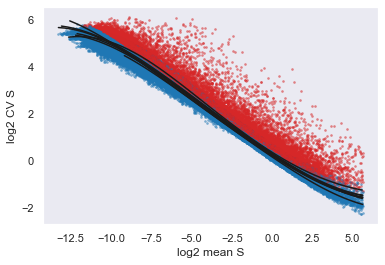

In [12]:
# Get copy of scores separate time point unnormalized datasets
for key in datasets.keys():
    print(key)
    ds = datasets[key]
    sc.pp.normalize_total(ds)
    cv_mean_selected, cv_mean_score = filter_cv_vs_mean(ds.X.T.toarray(), N=2000, max_expr_avg=50)
    ds.var["cv_mean_score"] = cv_mean_score
    ds.var["cv_mean_selected"] = cv_mean_selected
    datasets[key] = ds

# CV score theshold changes, trapezoid rule AUC

In [13]:
THRESHOLD = 0.3
# Different CV score thresholds for keeping genes    
print("THRESHOLD =", THRESHOLD)

ngs = []
selected_genes = {}
for key in datasets.keys():
    curr_vlm = datasets[key]
    keep_genes = list(curr_vlm.var.index[curr_vlm.var["cv_mean_score"] > THRESHOLD])
    ngs.append(keep_genes)
    selected_genes.update({g: True for g in keep_genes})

print(len(selected_genes))

THRESHOLD = 0.3
6324


In [14]:
for i in ngs:
    print(len(i))

464
2060
2522
2712
1841
1397
976


In [15]:
ms_cum = []
cs_cum = []
ms_noncum = []
cs_noncum = []

In [16]:
# Get AUC for each individual time point
NUM_PCS = 1000
for curr_day in all_days:
    counts = cell_filtered_days[curr_day]["counts"]
    genes = cell_filtered_days[curr_day]["rows"]
    cells = cell_filtered_days[curr_day]["columns"]

    gene_filter_array = np.array([g in selected_genes for g in genes])
    np.random.seed(0)
    subset = {c:True for c in np.random.choice(cells, NUM_PCS, replace=False)}
    cell_filter_array = np.array([i in subset for i in cells])
    counts = counts[gene_filter_array, :][:, cell_filter_array]

    pca = PCA()
    pcs = pca.fit_transform(counts.T)
    evr = pca.explained_variance_ratio_

    # Cumulative sum AUC
    measured_cum = trapz(np.cumsum(evr))
    control_cum = trapz([i/NUM_PCS for i in range(0, NUM_PCS)]) # control

    # Non-cumulative sum AUC
    measured_noncum = trapz(evr)
    control_noncum = trapz([1/NUM_PCS]*NUM_PCS) # control

    print(curr_day, measured_cum, control_cum, measured_noncum, control_noncum)
    ms_cum.append(measured_cum)
    cs_cum.append(control_cum)
    ms_noncum.append(measured_noncum)
    cs_noncum.append(control_noncum)

ms_cum_dict["Trapezoid"][THRESHOLD] = ms_cum
cs_cum_dict["Trapezoid"][THRESHOLD] = cs_cum
ms_noncum_dict["Trapezoid"][THRESHOLD] = ms_noncum
cs_noncum_dict["Trapezoid"][THRESHOLD] = cs_noncum
ngs_dict["Trapezoid"][THRESHOLD] = ngs

D0 799.06494 499.0005 0.96352804 0.9990000000000003
D7 867.8598 499.0005 0.8534983 0.9990000000000003
D14 873.75574 499.0005 0.8808396 0.9990000000000003
D30 824.605 499.0005 0.9218608 0.9990000000000003
D38 829.2284 499.0005 0.9099194 0.9990000000000003
D45 808.91797 499.0005 0.91983044 0.9990000000000003
D60 802.3246 499.0005 0.91588336 0.9990000000000003


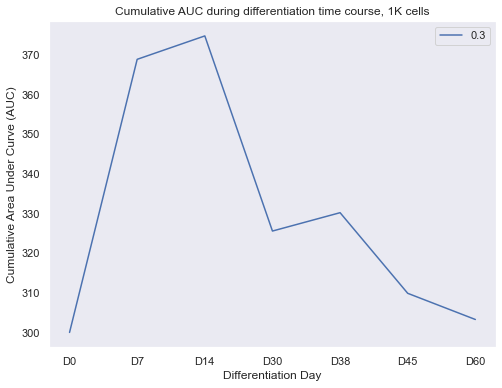

In [17]:
thresholds = list(ms_cum_dict["Trapezoid"].keys())
thresholds

plt.figure(None, (8, 6))
for thres in thresholds:
    ms = ms_cum_dict["Trapezoid"][thres]
    cs = cs_cum_dict["Trapezoid"][thres]
    plt.plot(range(0, 7), np.array(ms) - np.array(cs), label=thres)
plt.xticks(range(0, 7), labels=all_days)
plt.xlabel("Differentiation Day")
plt.ylabel("Cumulative Area Under Curve (AUC)")
plt.title("Cumulative AUC during differentiation time course, 1K cells")
plt.legend(loc=1)
#plt.savefig("PCA variance AUC during differentiation time course, 700 cells.png", dpi=300)

In [18]:
ms_cum_dict["TrapezoidGSS_Final"] = {}
cs_cum_dict["TrapezoidGSS_Final"] = {}
ms_noncum_dict["TrapezoidGSS_Final"] = {}
cs_noncum_dict["TrapezoidGSS_Final"] = {}
ngs_dict["TrapezoidGSS_Final"] = {}

In [19]:
print("THRESHOLD =", THRESHOLD)

ngs = []
selected_genes = {}
for key in datasets.keys():
    curr_vlm = datasets[key]
    keep_genes = list(curr_vlm.var.index[curr_vlm.var["cv_mean_score"] > THRESHOLD])
    ngs.append(keep_genes)
    selected_genes.update({g: True for g in keep_genes})

print(len(selected_genes))

THRESHOLD = 0.3
6324


In [20]:
ms_cum = {d:[] for d in all_days}
cs_cum = {d:[] for d in all_days}
ms_noncum = {d:[] for d in all_days}
cs_noncum = {d:[] for d in all_days}

# Get AUC for each individual time point
NUM_CELLS = 800
NUM_GENES = int(round(len(selected_genes)/2))
NUM_ITERS = 100
print(NUM_CELLS, NUM_GENES, NUM_ITERS)
for curr_day in all_days:
    for i in range(0, NUM_ITERS):
        counts = cell_filtered_days[curr_day]["counts"]
        genes = cell_filtered_days[curr_day]["rows"]
        cells = cell_filtered_days[curr_day]["columns"]

        gene_subset = np.random.choice(list(selected_genes.keys()), NUM_GENES, replace=False)
        gene_filter_array = np.array([i in gene_subset for i in genes])

        cell_subset = {c:True for c in np.random.choice(cells, NUM_CELLS, replace=False)}
        cell_filter_array = np.array([i in cell_subset for i in cells])

        counts = counts[gene_filter_array, :][:, cell_filter_array]

        pca = PCA()
        pcs = pca.fit_transform(counts.T)
        evr = pca.explained_variance_ratio_

        # Cumulative sum AUC
        assert(NUM_CELLS <= NUM_GENES)
        NUM_PCS = min(NUM_CELLS, NUM_GENES)
        measured_cum = trapz(np.cumsum(evr))
        control_cum = trapz([i/NUM_PCS for i in range(0, NUM_PCS)]) # control

        # Non-cumulative sum AUC
        measured_noncum = trapz(evr)
        control_noncum = trapz([1/NUM_PCS]*NUM_PCS) # control

        if i%100==0:
            print("ITER =", i, curr_day, measured_cum, control_cum, measured_noncum, control_noncum)

        ms_cum[curr_day].append(measured_cum)
        cs_cum[curr_day].append(control_cum)
        ms_noncum[curr_day].append(measured_noncum)
        cs_noncum[curr_day].append(control_noncum)

ms_cum_dict["TrapezoidGSS_Final"][THRESHOLD] = ms_cum
cs_cum_dict["TrapezoidGSS_Final"][THRESHOLD] = cs_cum
ms_noncum_dict["TrapezoidGSS_Final"][THRESHOLD] = ms_noncum
cs_noncum_dict["TrapezoidGSS_Final"][THRESHOLD] = cs_noncum
ngs_dict["TrapezoidGSS_Final"][THRESHOLD] = ngs

800 3162 100
ITER = 0 D0 667.22 399.000625 0.963383 0.9987499999999998
ITER = 0 D7 700.2593 399.000625 0.8681281 0.9987499999999998
ITER = 0 D14 711.1215 399.000625 0.8781791 0.9987499999999998
ITER = 0 D30 672.3734 399.000625 0.9215733 0.9987499999999998
ITER = 0 D38 682.9619 399.000625 0.90532 0.9987499999999998
ITER = 0 D45 668.56067 399.000625 0.9126228 0.9987499999999998
ITER = 0 D60 667.18695 399.000625 0.9100227 0.9987499999999998


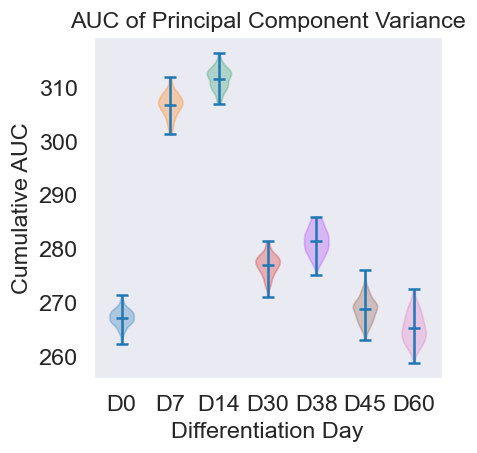

In [21]:
#AUC 800 cells, 1K iter, thres=0.3
sc.settings.set_figure_params(vector_friendly=True)
sc.settings.set_figure_params(dpi=120)
sns.set_style("dark")

ms = ms_cum_dict["TrapezoidGSS_Final"][0.3]
cs = cs_cum_dict["TrapezoidGSS_Final"][0.3]
ds = []
for day in all_days:
    ds.append(np.array(ms[day]) - np.array(cs[day]))

parts = plt.violinplot(ds, showmeans=True)
for i in range(0, len(parts['bodies'])):
    pc = parts["bodies"][i] 
    c = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2'][i]
    pc.set_color(c)

plt.xticks(range(1, 8), labels=all_days)
plt.xlabel("Differentiation Day")
plt.ylabel("Cumulative AUC")
plt.title("AUC of Principal Component Variance")
plt.tight_layout()
plt.show()